In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 8, 4

import sys;import os;
module_path = os.path.abspath(os.path.join('..')).split('PythonCode')[0]+'PythonCode'
if module_path not in sys.path: sys.path.append(module_path+"/")
    
import Plib.ML.Models as ml
import Plib.Signals.TAnalysis as ta
import Plib.Signals.Filters as flt
import pickle

import warnings
warnings.filterwarnings("ignore")


In [2]:
fname='goldReg.pickle'
with open(fname, 'rb') as handle:
    data = pickle.load(handle) 

#Aligna data in sdata
min_data=[]
for k in data.keys(): min_data.append(data[k].index.min())
d1=str(max(min_data)) 
max_data=[]
for k in data.keys(): max_data.append(data[k].index.max())
d2=str(min(max_data)) 
sdata={}
for k in data.keys():
    df=data[k]
    df=df[(df.index>=d1) & (df.index<=d2)]
    sdata[k]=df 

### Class definition for strategy

In [3]:
class MLTRNNK(ml.RNNCK):
                
    @staticmethod
    def fs_generation(df,l_rets=[3,15,30],w_sma=[3,15,60],drop_nan=True):
        d1=ta.getVolumeGap(df)
        d1=ta.getDailyChange(d1)
        d1=ta.getOpenSpread(d1)
        d1=ta.getLaggedRets(d1,periods=l_rets)
        d1=ta.getSMAs(d1,periods=w_sma)
        d1=ta.getMarketUpDown(d1)
        fast=min(w_sma)
        d1=ta.getSMACorr(d1,lbl_sma='sma_'+str(fast))
        nan_index=max(max(w_sma),max(l_rets))
        if drop_nan:
            d1=d1[nan_index:]
            d1=d1.dropna()
        features=[c for c in d1.columns if c not in ['Open','High','Low','Close','Adjusted_close','Volume','MarketUpDown_Close1day']]
        return d1,list(features)
    
    @staticmethod
    def makeStudy(df,features=[],regrnd1='',test_periods=252,split=0.85,table=False):
        df=df[:-test_periods].copy()
        df1 = MLTRNNK.scaling(df[[*([regrnd1]+features)]],params={'method':'minmax','exclude':[]})
        
        nparams={'hlayers': 6, 'nnlayers': [128,128,128,128,128,128], 'dropOut':1, 'earlyStop':True, 
                                'esMetric':'mae', 'batchNorm': 4, 'sAlgo':'mbgd', 'sParam': 100}
        initializer={'sigma':1,'mode':'fan_avg', 'distribution':'uniform'}
        optimizer={'optimizer':'adam', 'loss':'mse','learning_rate' : 0.0015, 'metrics':['mae']}
        stats = MLTRNNK.rnnkClassifier(df1,regrnd1,t = split ,nparams=nparams, 
                                       initializer=initializer, optimizer=optimizer, table=table)
        return stats



### Data and plot

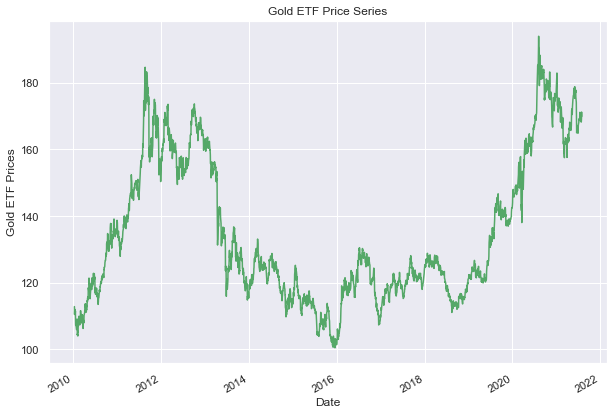

Open    High     Low   Close  Adjusted_close      Volume  \
Date                                                                     
2010-01-11  113.34  113.59  112.52  112.85          112.85  17252989.0   
2010-01-12  112.38  113.05  110.14  110.49          110.49  29182550.0   
2010-01-13  110.92  111.57  109.57  111.54          111.54  20013968.0   

            volumeGap_  dailyChange_   OD_   OL_  fractHigh_  fractLow_  \
Date                                                                      
2010-01-11    0.081899     -0.004323  1.82  1.76    0.002206   0.007235   
2010-01-12    0.525586     -0.016818 -0.96 -1.21    0.005962   0.019932   
2010-01-13   -0.377140      0.005590 -1.46 -2.13    0.005860   0.012171   

            lagRets_3  lagRets_15  lagRets_30       sma_3      sma_15  \
Date                                                                    
2010-01-11   1.201686    5.133222   -3.232722  111.680000  108.886000   
2010-01-12  -0.297780    1.413492   -3.971841  111.570000  108.988667   
2010-01-13   0.152644    4.291725   -3.545486  111.626667  109.294667   

                sma_60  MarketUpDown_Close1day  corr_sma_3  
Date                                                        
2010-01-11  109.078433                      -1    0.873720  
2010-01-12  109.205600                       1    0.922250  
2010-01-13  109.344933                       1    0.883895

In [4]:
# Instantiate Linreg algo
algo=MLTRNNK()

# Select data
gold = sdata['gld_etf']

# Clean data
gold= algo.cleanData(gold)

# Create Features
gold,features=algo.fs_generation(gold)

# Plot the closing price of GLD 11 
gold.Close.plot(figsize=(10, 7),color='g')
plt.ylabel("Gold ETF Prices")
plt.title("Gold ETF Price Series")
plt.show()
gold.head(3)

In [5]:
def algot(gd_test,signal):
    
    gd_test['Signal'] = signal
    # Compute GLD returns 
    gd_test['Ret'] = (gd_test['Close']-gd_test['Close'].shift(1))/gd_test['Close'].shift(1)

    # Compute strategy returns(
    gd_test['Ret1'] = gd_test['Ret']*(gd_test['Signal'].shift(1))
    return gd_test

def plotReturns(df):
    plt.figure(figsize=(10,5))
    plt.plot(((1+df['Ret']).cumprod()),color='r',label='GLD Returns')
    plt.plot(((1+df['Ret1']).cumprod()),color='g',label='Strategy Returns')
    plt.legend()
    plt.show()
    df.head(5)

    

### Test and Diagnostics

------------------------------------------
Accuracy [0.5094 0.5094]
Recall [0.1285 0.8186]
MCC -0.0722
Specificity [0.8186 0.1285]
F1_score [0.1901 0.6481]
Cohens Kappa -0.0564
------------------------------------------


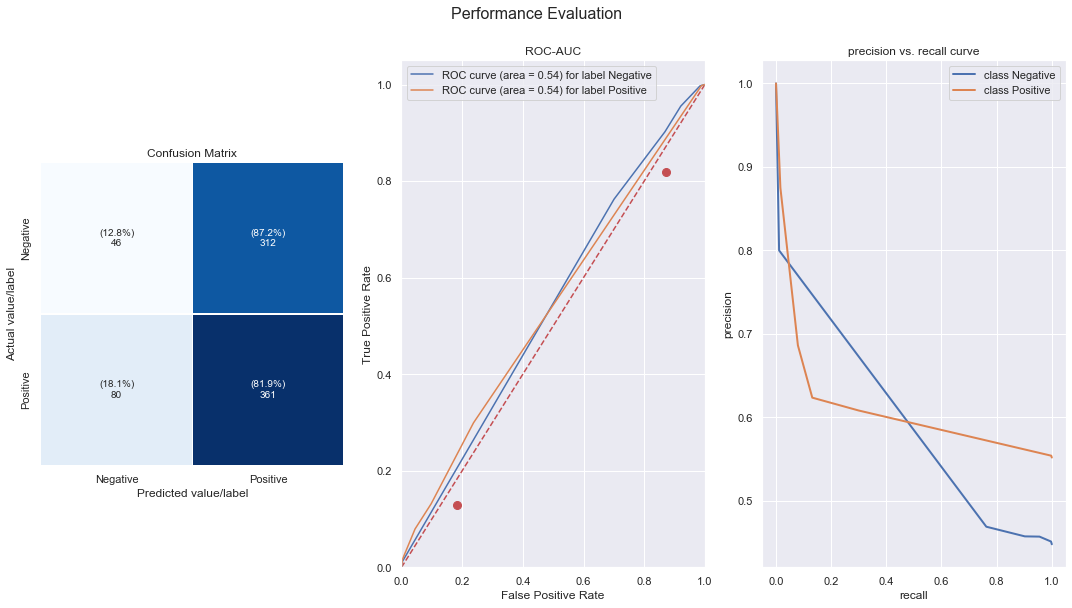

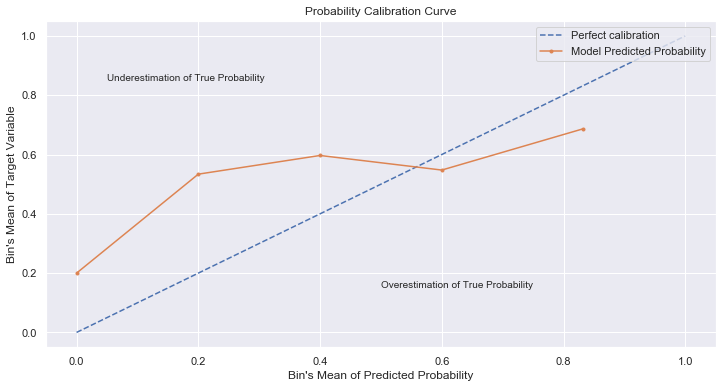

Transformation of Probabilities:
------------------------------------------
Model                                 0.06
Model + Isotonic regression           0.0
Model + Logistic regression           0.03
Platt Scaling * Model                 -999
------------------------------------------


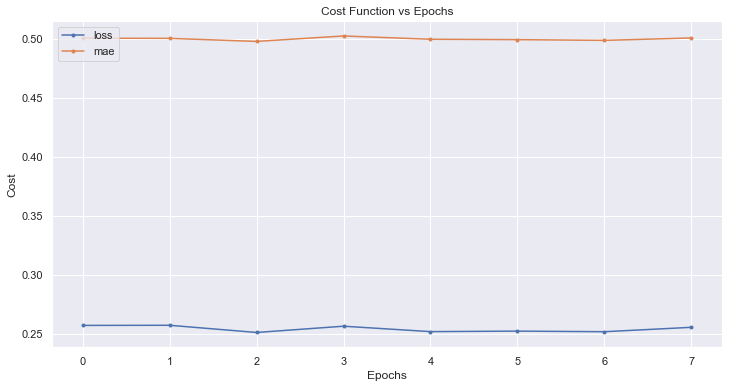

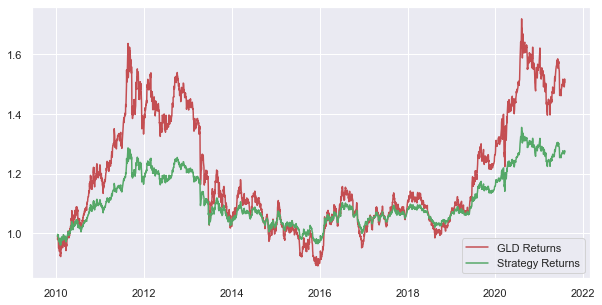

In [6]:
test_periods=252
split=0.7
regrnd1='MarketUpDown_Close1day'
gold_scaled = algo.scaling(gold[[*([regrnd1]+features)]],params={'method':'minmax','exclude':[]})

ret=algo.makeStudy(gold,features,regrnd1,
                        test_periods=test_periods,
                        split=split,table=True)

strategy=algot(gold,algo.getProbs(ret['model'],gold_scaled,features))

plotReturns(strategy)


### Test

Start:  2020-07-30
End:  2021-07-28


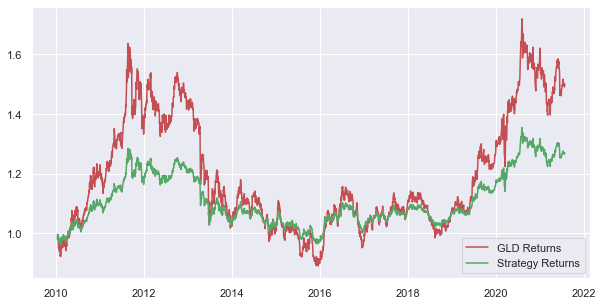

In [7]:
test_periods=252
regrnd1='MarketUpDown_Close1day'

# Strategy data
strategy=gold[:int(len(gold[:-test_periods]))].copy()
gold_scaled = algo.scaling(gold[[*([regrnd1]+features)]],params={'method':'minmax','exclude':[]})
ret=algo.makeStudy(gold,features,regrnd1='MarketUpDown_Close1day',
                            test_periods=test_periods,
                            split=0.75,table=False)

# Test the strategy dy-by-day
print('Start: ', str(strategy.tail(1).index.date[0]))
for d in range(1,test_periods-1):
    last_day=algot(gold[:-test_periods+d],algo.getProbs(ret['model'],gold_scaled[:-test_periods+d],features)).iloc[-1]
    strategy=strategy.append(last_day)
print('End: ', str(strategy.tail(1).index.date[0]))

plotReturns(strategy)


### Features Selection

In [7]:
test_periods=252
gold_study=gold[:-test_periods].copy()
features_set=['sma_3','sma_15','sma_60','volumeGap_','dailyChange_','OD_','OL_',
 'lagRets_3','lagRets_15','lagRets_30','corr_sma_3']

d1,d2=algo.fs_analysis(gold_study[[*features]])


Features with Lowest Variance volumeGap_ dailyChange_ OD_ OL_ fractHigh_ fractLow_ sma_15 corr_sma_3 LowVar 
 
 count 
 2666.000000 
 2666.000000 
 2666.000000 
 2666.000000 
 2666.000000 
 2666.000000 
 2666.000000 
 2666.000000 
 
 
 mean 
 0.000000 
 0.000000 
 0.000100 
 -0.002500 
 0.000000 
 0.000000 
 0.577400 
 0.003500 
 
 
 std 
 0.002100 
 0.000000 
 0.005700 
 0.004900 
 0.000000 
 0.000000 
 0.005800 
 0.000900 
 
 
 min 
 -0.008300 
 -0.000200 
 -0.048500 
 -0.049300 
 0.000000 
 0.000000 
 0.553900 
 -0.001600 
 
 
 25% 
 -0.001400 
 -0.000000 
 -0.002900 
 -0.004700 
 0.000000 
 0.000000 
 0.574000 
 0.002900 
 
 
 50% 
 -0.000100 
 0.000000 
 0.000200 
 -0.002100 
 0.000000 
 0.000000 
 0.577300 
 0.003500 
 
 
 75% 
 0.001300 
 0.000000 
 0.003200 
 0.000200 
 0.000000 
 0.000000 
 0.580900 
 0.004200 
 
 
 max 
 0.008300 
 0.000200 
 0.042200 
 0.026500 
 0.000200 
 0.000200 
 0.598600 
 0.005300 
 
            Features with Lowest Correlation volumeGap_ dailyChange_ OD_ lagRets_3 lagRets_15 sma_3 corr_sma_3 
 
 count 
 2666.000000 
 2666.000000 
 2666.000000 
 2666.000000 
 2666.000000 
 2666.000000 
 2666.000000 
 
 
 mean 
 0.000000 
 0.000000 
 0.027000 
 0.071200 
 0.338900 
 131.085700 
 0.775500 
 
 
 std 
 0.467400 
 0.006600 
 1.358800 
 1.692900 
 3.718100 
 18.592500 
 0.168200 
 
 
 min 
 -1.642900 
 -0.051400 
 -12.650000 
 -12.895500 
 -15.414800 
 101.576700 
 -0.308800 
 
 
 25% 
 -0.322400 
 -0.003000 
 -0.620000 
 -0.888100 
 -1.895200 
 117.734200 
 0.682600 
 
 
 50% 
 -0.025000 
 0.000000 
 0.040000 
 0.080700 
 0.294100 
 124.583300 
 0.815300 
 
 
 75% 
 0.295200 
 0.003000 
 0.710000 
 1.024600 
 2.674200 
 142.509200 
 0.908500 
 
 
 max 
 1.719000 
 0.053400 
 10.825000 
 11.127200 
 17.036500 
 184.213300 
 0.995900

In [9]:
test_periods=252
gold_study=gold[:-test_periods].copy()
regrnd1='MarketUpDown_Close1day'

min_features=['sma_3','sma_15','sma_60',]
add_features=['volumeGap_','dailyChange_','OD_','OL_']#,'lagRets_3','lagRets_15','lagRets_30','corr_sma_3']

model=algo.rnnkClassifier

nparams={'hlayers': 6, 'nnlayers': [128,128,128,128,128,128], 'dropOut':1, 'earlyStop':True, 
        'esMetric':'mae', 'batchNorm': 4, 'sAlgo':'mbgd', 'sParam': 100}
initializer={'sigma':1,'mode':'fan_avg', 'distribution':'uniform'}
optimizer={'optimizer':'adam', 'loss':'mse','learning_rate' : 0.0015, 'metrics':['mae']}
params=[nparams,initializer,optimizer,False]

df=algo.scaling(gold_study[[*([regrnd1]+min_features+add_features)]],params={'method':'minmax','exclude':[]})
features_comb=algo.fs_combin(df,min_features,regrnd1,add_features,model,params)
print(features_comb)

['sma_3', 'sma_15', 'sma_60', 'volumeGap_', 'dailyChange_']


### Model Parameters

Best Solution:  2 ('MarketUpDown_Close1day', 1, {'hlayers': 5, 'nnlayers': [128, 128, 128, 128, 128], 'dropOut': 1, 'earlyStop': True, 'esMetric': 'mae', 'batchNorm': 4, 'sAlgo': 'mbgd', 'sParam': 100}, {'sigma': 1, 'mode': 'fan_avg', 'distribution': 'uniform'}, {'optimizer': 'adam', 'loss': 'mse', 'learning_rate': 0.0015, 'metrics': ['mae']}, False)


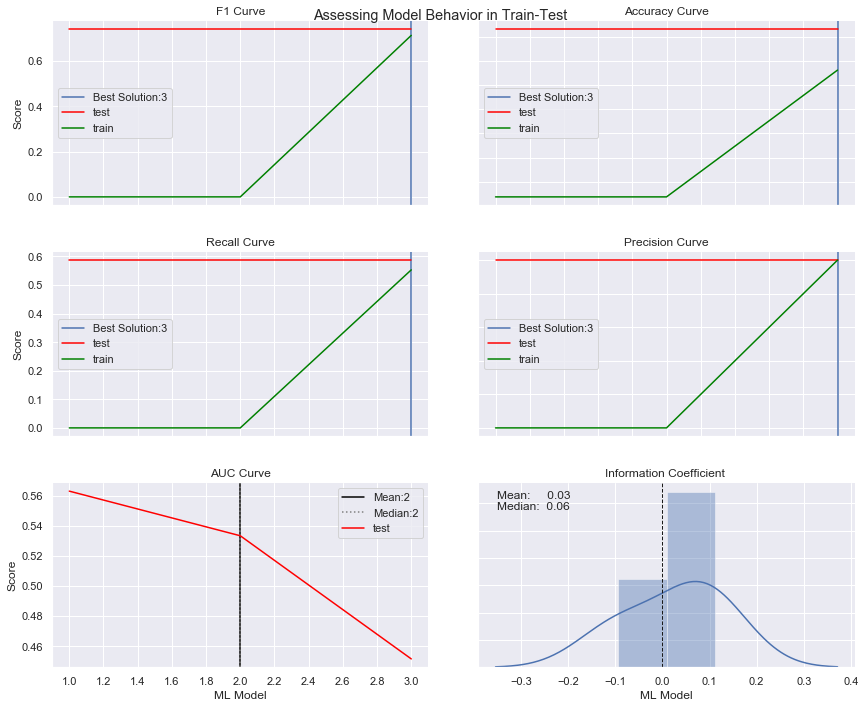

In [8]:
regrnd1='MarketUpDown_Close1day'
model=algo.rnnkClassifier
df=algo.scaling(gold_study[[*([regrnd1]+features_set)]],params={'method':'minmax','exclude':[]})

options={'dropOut':1, 'earlyStop':True,'esMetric':'mae', 'batchNorm': 4, 'sAlgo':'mbgd', 'sParam': 100}
params=algo.make_params(regrnd1,nparmz=False, initz=False,optz=False, options=options)
score=algo.md_htDiag(df,regrnd1,model,params,how='awf',Nproc=0)
best_param=algo.md_htDiagPlot(score,(12,10))
print('Best Solution: ',best_param, params[best_param])

Best Solution:  0 ('MarketUpDown_Close1day', 1, {'hlayers': 3, 'nnlayers': [128, 128, 128], 'dropOut': 1, 'earlyStop': True, 'esMetric': 'mae', 'batchNorm': 4, 'sAlgo': 'mbgd', 'sParam': 100}, {'sigma': 1, 'mode': 'fan_avg', 'distribution': 'uniform'}, {'optimizer': 'adam', 'loss': 'mse', 'learning_rate': 0.0015, 'metrics': ['mae']}, False)


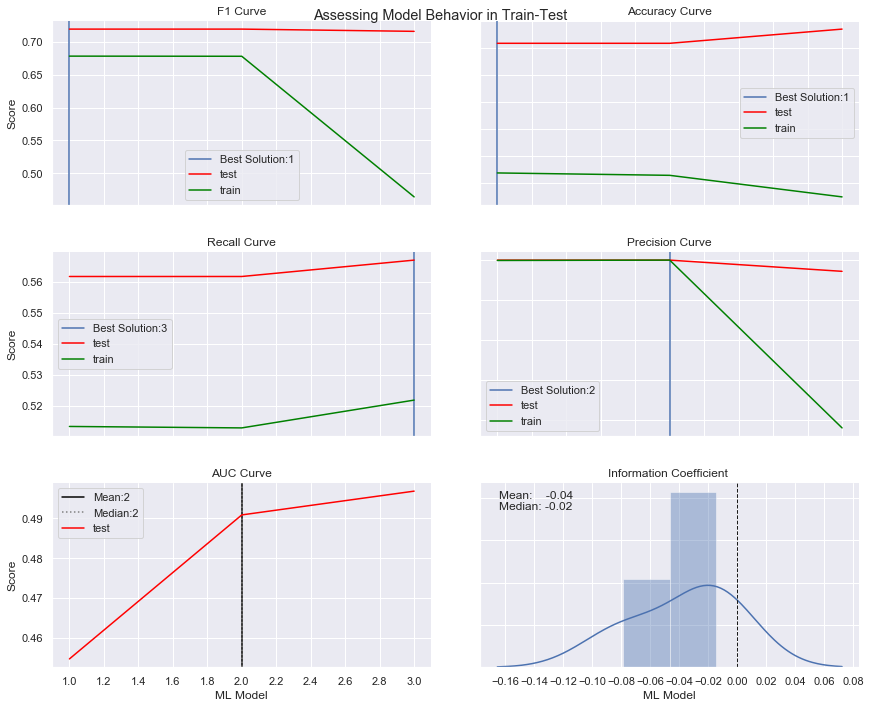

In [9]:
regrnd1='MarketUpDown_Close1day'
model=algo.rnnkClassifier
df=algo.scaling(gold_study[[*([regrnd1]+features_set)]],params={'method':'minmax','exclude':[]})

options={'dropOut':1, 'earlyStop':True,'esMetric':'mae', 'batchNorm': 4, 'sAlgo':'mbgd', 'sParam': 100}
params=algo.make_params(regrnd1,nparmz=False, initz=False,optz=False, options=options)
score=algo.md_htDiag(df,regrnd1,model,params,how='cv',Nproc=0)
best_param=algo.md_htDiagPlot(score,(12,10))
print('Best Solution: ',best_param, params[best_param])

### Interpretability and Feature Importance with LIME

Explanation Score:  0.45671351288613726


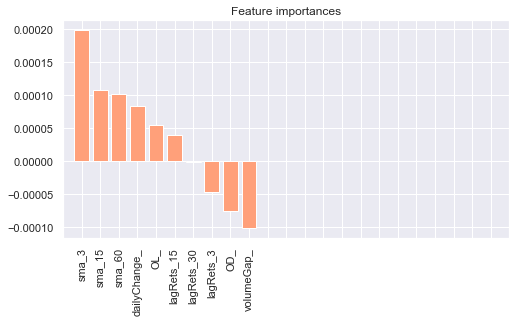

imp
sma_3         0.000198
sma_15        0.000108
sma_60        0.000101
dailyChange_  0.000083
OL_           0.000055
lagRets_15    0.000040
lagRets_30   -0.000002
lagRets_3    -0.000047
OD_          -0.000075
volumeGap_   -0.000101

In [13]:
mymodel=ret['model']

lime_gold=algo.scaling(gold,params={'method':'minmax','exclude':[]})

MLTRNNK.fs_localInt(lime_gold, features_set, regrnd1,
                   nclasses=['Up','Down'],
                   which_obs=11,model=mymodel)


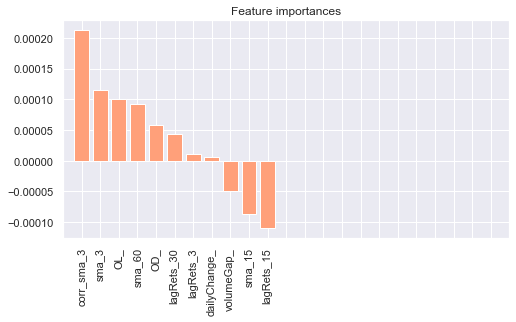

imp
corr_sma_3    0.000212
sma_3         0.000115
OL_           0.000101
sma_60        0.000093
OD_           0.000058
lagRets_30    0.000044
lagRets_3     0.000010
dailyChange_  0.000007
volumeGap_   -0.000049
sma_15       -0.000087
lagRets_15   -0.000109

In [14]:
MLTRNNK.fs_globalInt(lime_gold, features_set, regrnd1,
                  nclasses=['Up','Down'],ninsta=11, model=mymodel, 
                  mtype='c', test_periods=252)